In [ ]:
#!pip install renumics-spotlight datasets


In [1]:
import os
os.environ['PYDEVD_USE_CYTHON'] = 'NO'




Visualize with features extracted from foundational models

In [10]:
import pandas as pd
from datasets import Dataset
from renumics import spotlight

dataset_name = "wikiart"
feature = 'image_features'
if dataset_name == 'wikiart':
    df = pd.read_pickle('DATA/Dataset/wikiart/wikiartINFL.pkl')
elif dataset_name == 'fashion':
    df = pd.read_pickle('DATA/Dataset/iDesigner/idesignerINFL.pkl')
# all_artist_names = set(df['artist_name'])
# df['influenced_by'] = df['influenced_by'].apply(lambda artists_list: [artist for artist in artists_list if artist in all_artist_names])

#df['image_features'] = df["image_features"].apply(lambda x: x.numpy())
df.image_features = df.image_features.apply(lambda x: x.numpy())
df['influenced_by_str'] = df['influenced_by'].apply(lambda x: ' '.join(x))
if dataset_name == 'wikiart':
    df.drop(columns = ['title'],inplace=True)
    df.text_features = df.text_features.apply(lambda x: x.numpy())
    df.image_text_features = df.image_text_features.apply(lambda x: x.numpy())

# dataset = Dataset.from_pandas(df)

# spotlight.show(dataset, dtype={feature:spotlight.Embedding})


Visualize with finetuned 

In [11]:
from Triplet_Network import TripletResNet_features
import torch

model_path = f'trained_models/{dataset_name}/stratified_artists/TripletResNet_{feature}_posfaiss_negrandom_100_margin1_notrans_epoch_30/model.pth'
model = TripletResNet_features(df.loc[0,feature].shape[0])
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()
df[feature] = df[feature].apply(lambda x: torch.from_numpy(x))
df[f'trained_{feature}'] = df[feature].apply(lambda x: model.forward_once(x).detach())
df[f'trained_{feature}'] = df[f'trained_{feature}'].apply(lambda x: x.numpy())
df[feature] = df[feature].apply(lambda x: x.numpy())


# dataset = Dataset.from_pandas(df)

# spotlight.show(dataset, dtype={f'trained_{feature}':spotlight.Embedding})

DISTANCES

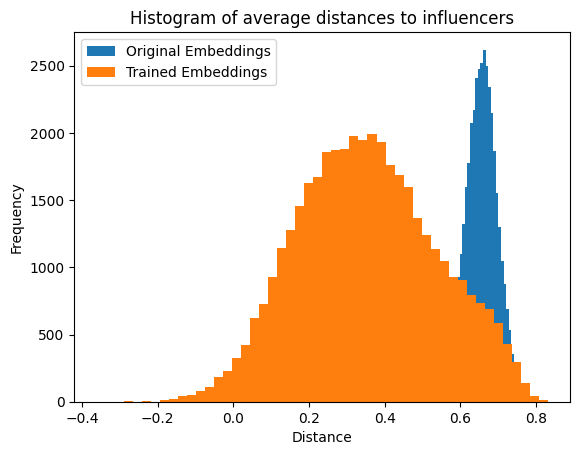

In [12]:
from sklearn.metrics.pairwise import euclidean_distances
#use cosine similarity instead of euclidean distance
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def viz_dist_embeddingss(df,feature):
    embeddings = np.vstack(df[feature].values)
    embeddings_trained = np.vstack(df[f'trained_{feature}'].values)
    # Calculate distances between observations and their influencers
    influencer_distances = []
    influencer_distances_trained = []

    for i, obs in df.iterrows():
        obs_vector = embeddings[i]
        influencers = obs['influenced_by']
        influencer_vectors = embeddings[df['artist_name'].isin(influencers)]

        obs_vector_trained = embeddings_trained[i]
        influencer_vectors_trained = embeddings_trained[df['artist_name'].isin(influencers)]
        
        if len(influencer_vectors) > 0:
            distances_to_influencers = cosine_similarity([obs_vector], influencer_vectors)
            avg_distance_to_influencers = np.mean(distances_to_influencers)
            influencer_distances.append(avg_distance_to_influencers)

            distances_to_influencers_trained = cosine_similarity([obs_vector_trained], influencer_vectors_trained)
            avg_distance_to_influencers_trained = np.mean(distances_to_influencers_trained)
            influencer_distances_trained.append(avg_distance_to_influencers_trained)

        else:
            influencer_distances.append(np.nan)
            influencer_distances_trained.append(np.nan)

    df['influencer_distance_cosine'] = influencer_distances
    df['influencer_distance_cosine_trained'] = influencer_distances_trained

    #Analyze and plot influencer distances
    plt.hist(df['influencer_distance_cosine'].dropna(), bins=50)
    plt.hist(df['influencer_distance_cosine_trained'].dropna(), bins=50)
    plt.legend(['Original Embeddings', 'Trained Embeddings'])
    plt.title('Histogram of average distances to influencers')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.show()
    return df

df_ = viz_dist_embeddingss(df,feature)